# IBM Data Science Capstone - The Battle of Neighborhoods - Week 1

**Author: Rodrigo Menon**

[Github](https://github.com/rodrigomenon)

## Business Problem and Metodology and Audience

**Business Problem:** In this project, we will seek to answer the following question: Which neighborhood in the city of São Paulo is the best to establish a pet shop service?

**Metodology:** We will use data from geographic coordinates of the city of São Paulo to map its neighborhoods.

Next, we will use the Foursquare API to collect neighborhood data and information about venues, such as category and quantities, to help us identify and suggest potential places to start a pet business.

**Audience:** This project should be interesting for potential entrepreneurs in the pet shop industry, as well as consumers who want to better understand the market and the availability of this type of service in the city of São Paulo.

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style='darkgrid')

import requests                         # library to handle requests
from bs4 import BeautifulSoup           # library for pulling data out of HTML and XML files
from pandas import json_normalize       # transform json file into a pandas data frame
from geopy.geocoders import Nominatim   # convert the address into latitude and longitude values
import folium                           # map rendering library
import urllib.request
from sklearn.cluster import KMeans      # Kmeans
from scipy.cluster.hierarchy import dendrogram, linkage

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 20)

## Session 1- Load and Data Wrangling

### Load Data

**Distribution of Households, by Income Groups per Capita, by Districts** - [source](http://produtos.seade.gov.br/produtos/msp/index.php?tip=met4&opt=t&subtema=null&tema=ren) 

Minimum reference salary for the 2000 Census: R$ 151.00.


In [2]:
df_income = pd.read_excel('data/ren1_001.xls')
df_income.dropna(axis=0, inplace=True)
df_income.drop(3, inplace=True)
df_income.reset_index(drop=True, inplace=True)

In [3]:
df_income.rename(columns={'Distritos': 'Neighborhood',
                          'Menos de 2 SM': 'Less than 2 Minimum Wage',
                          'De 2 a Menos de 5 SM': 'From 2 to Less than 5 Minimum Wage',
                          'De 5 a Menos de 10 SM': 'From 5 to Less than 10 Minimum Wage',
                          'De 10 a Menos de 15 SM': 'From 10 to Less than 15 Minimum Wage',
                          'De 15 a Menos de 25 SM': 'From 15 to Less than 25 Minimum Wage',
                          'De 25 SM e Mais ': 'From 25 Minimum Wage and more'}, inplace=True)
df_income.head()

,Neighborhood,Less than 2 Minimum Wage,From 2 to Less than 5 Minimum Wage,From 5 to Less than 10 Minimum Wage,From 10 to Less than 15 Minimum Wage,From 15 to Less than 25 Minimum Wage,From 25 Minimum Wage and more
0,Água Rasa,8.33,17.31,26.60,14.01,15.96,17.78
1,Alto de Pinheiros,3.47,5.44,12.22,9.30,15.85,53.72
2,Anhanguera,18.29,34.93,31.91,8.90,3.99,1.98
3,Aricanduva,11.64,24.95,28.47,13.72,13.33,7.88
4,Artur Alvim,12.03,23.22,31.51,15.87,12.60,4.77


**fixing the names of the neighborhoods that were misspelled**

In [4]:
df_income['Neighborhood'] = df_income['Neighborhood'].replace(['Guaianazes','Moóca', 'Vila Curuça', 'Sao Domingos'], 
                                                              ['Guaianases', 'Mooca', 'Vila Curuçá', 'São Domingos'])

**Loading the Demographic data of the neighborhoods belonging to the Subprefectures**

In [5]:
df_neighborhoods = pd.read_html('https://www.prefeitura.sp.gov.br/cidade/secretarias/subprefeituras/subprefeituras/dados_demograficos/index.php?p=12758')[0]
df_neighborhoods

,Subprefeituras,Distritos,Área (km²),População (2010),Densidade Demográfica (Hab/km²)
0,Aricanduva,Aricanduva,660.0,89.622,13.579
1,Aricanduva,Carrão,750.0,83.281,11.104
2,Aricanduva,Vila Formosa,740.0,94.799,12.811
3,Aricanduva,TOTAL,2150.0,267.702,12.451
4,Butantã,Butantã,1250.0,54.196,4.336
5,Butantã,Morumbi,1140.0,46.957,4.119
6,Butantã,Raposo Tavares,1260.0,100.164,7.950
7,Butantã,Rio Pequeno,970.0,118.459,12.212
8,Butantã,Vila Sônia,990.0,108.441,10.954
9,Butantã,TOTAL,5610.0,428.217,7.633


### Data Wrangling

**Drop columns that will not be use**

In [6]:
df_neighborhoods.drop(df_neighborhoods.columns[[2,3,4]], axis=1, inplace=True)
df_neighborhoods.head()

,Subprefeituras,Distritos
0,Aricanduva,Aricanduva
1,Aricanduva,Carrão
2,Aricanduva,Vila Formosa
3,Aricanduva,TOTAL
4,Butantã,Butantã


**Renaming the columns**

In [7]:
df_neighborhoods.rename(columns={'Subprefeituras': 'Subprefecture',
                                 'Distritos': 'Neighborhood'}, inplace=True)
df_neighborhoods.head()

,Subprefecture,Neighborhood
0,Aricanduva,Aricanduva
1,Aricanduva,Carrão
2,Aricanduva,Vila Formosa
3,Aricanduva,TOTAL
4,Butantã,Butantã


**Drop rows with "TOTAL" values**

In [8]:
rows_to_exclude = df_neighborhoods[df_neighborhoods['Neighborhood'] == 'TOTAL']
df_neighborhoods.drop(rows_to_exclude.index, inplace=True)

**Droping missing values**

In [9]:
df_neighborhoods.isnull().sum()

Subprefecture    0
Neighborhood     1
dtype: int64

In [10]:
# dropping the missing values
df_neighborhoods.dropna(axis=0, inplace=True)
df_neighborhoods

,Subprefecture,Neighborhood
0,Aricanduva,Aricanduva
1,Aricanduva,Carrão
2,Aricanduva,Vila Formosa
4,Butantã,Butantã
5,Butantã,Morumbi
6,Butantã,Raposo Tavares
7,Butantã,Rio Pequeno
8,Butantã,Vila Sônia
10,Campo Limpo,Campo Limpo
11,Campo Limpo,Capão Redondo


In [11]:
print(df_income.shape)
print(df_neighborhoods.shape)

(96, 7)
(96, 2)


**Merging the data frames to simplify the analysis**

In [12]:
df_merged = pd.merge(df_neighborhoods, df_income, how='inner', on='Neighborhood')
df_merged

,Subprefecture,Neighborhood,Less than 2 Minimum Wage,From 2 to Less than 5 Minimum Wage,From 5 to Less than 10 Minimum Wage,From 10 to Less than 15 Minimum Wage,From 15 to Less than 25 Minimum Wage,From 25 Minimum Wage and more
0,Aricanduva,Aricanduva,11.64,24.95,28.47,13.72,13.33,7.88
1,Aricanduva,Carrão,9.18,18.17,25.82,14.91,16.35,15.58
2,Aricanduva,Vila Formosa,8.10,20.08,28.69,13.91,13.08,16.14
3,Butantã,Butantã,4.93,10.60,16.23,12.10,18.25,37.88
4,Butantã,Morumbi,4.00,9.05,10.76,5.67,9.95,60.58
5,Butantã,Raposo Tavares,12.73,27.95,29.05,12.50,10.54,7.24
6,Butantã,Rio Pequeno,11.80,22.00,22.77,12.38,13.08,17.96
7,Butantã,Vila Sônia,9.58,16.05,20.05,11.28,13.96,29.07
8,Campo Limpo,Campo Limpo,16.07,28.25,28.71,11.26,9.96,5.76
9,Campo Limpo,Capão Redondo,18.30,32.80,29.82,9.36,6.50,3.22


In [13]:
df_merged.shape

(96, 8)

**The city of São Paulo is divided in five regions or zones: North, South, East, West, Center. Let's include this zones into our data frame.**

In [14]:
sp_zones = pd.read_csv('data/sp_regioes.csv', sep=';', encoding='UTF-8')
sp_zones

,Bairro,Região
0,Água Rasa,Leste
1,Alto de Pinheiros,Oeste
2,Anhanguera,Norte
3,Aricanduva,Leste
4,Artur Alvim,Leste
5,Barra Funda,Oeste
6,Bela Vista,Centro
7,Belém,Leste
8,Bom Retiro,Centro
9,Brás,Leste


In [15]:
sp_zones.shape

(96, 2)

**Rename columns names**

In [16]:
sp_zones.rename(columns={'Bairro': 'Neighborhood', 'Região': 'Zone'}, inplace=True)
sp_zones.head()

,Neighborhood,Zone
0,Água Rasa,Leste
1,Alto de Pinheiros,Oeste
2,Anhanguera,Norte
3,Aricanduva,Leste
4,Artur Alvim,Leste


**Translate zones names**

In [17]:
sp_zones.loc[sp_zones['Zone'] == 'Centro', 'Zone'] = 'Center'
sp_zones.loc[sp_zones['Zone'] == 'Leste', 'Zone'] = 'East'
sp_zones.loc[sp_zones['Zone'] == 'Norte', 'Zone'] = 'North'
sp_zones.loc[sp_zones['Zone'] == 'Oeste', 'Zone'] = 'West'
sp_zones.loc[sp_zones['Zone'] == 'Sul', 'Zone'] = 'South'

**Merging the new data frame _sp_zones_ with _df_sp_** 

In [18]:
df_sp = pd.merge(df_merged, sp_zones, how='inner', on='Neighborhood')
df_sp

,Subprefecture,Neighborhood,Less than 2 Minimum Wage,From 2 to Less than 5 Minimum Wage,From 5 to Less than 10 Minimum Wage,From 10 to Less than 15 Minimum Wage,From 15 to Less than 25 Minimum Wage,From 25 Minimum Wage and more,Zone
0,Aricanduva,Aricanduva,11.64,24.95,28.47,13.72,13.33,7.88,East
1,Aricanduva,Carrão,9.18,18.17,25.82,14.91,16.35,15.58,East
2,Aricanduva,Vila Formosa,8.10,20.08,28.69,13.91,13.08,16.14,East
3,Butantã,Butantã,4.93,10.60,16.23,12.10,18.25,37.88,West
4,Butantã,Morumbi,4.00,9.05,10.76,5.67,9.95,60.58,West
5,Butantã,Raposo Tavares,12.73,27.95,29.05,12.50,10.54,7.24,West
6,Butantã,Rio Pequeno,11.80,22.00,22.77,12.38,13.08,17.96,West
7,Butantã,Vila Sônia,9.58,16.05,20.05,11.28,13.96,29.07,West
8,Campo Limpo,Campo Limpo,16.07,28.25,28.71,11.26,9.96,5.76,South
9,Campo Limpo,Capão Redondo,18.30,32.80,29.82,9.36,6.50,3.22,South


In [19]:
df_sp.shape

(96, 9)

**Saving the data frame into a CSV file**

In [20]:
df_sp.to_csv('data/sp_neighborhoods.csv', index=False)

## Session 2 - Geocoding

**Using geopy to get the latitude and longitude of the neighborhoods**

In [21]:
df_sp = pd.read_csv('data/sp_neighborhoods.csv')

**Create a function to geocode the neighborhoods in São Paulo city**

In [22]:
latitudes = []
longitudes = []
def geolocation(address):
    geolocator = Nominatim(user_agent='sp_explorer')
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    latitudes.append(latitude)
    longitudes.append(longitude)

**Calling the function above for each neighborhood in São Paulo**

In [23]:
address = ''
teste = []
for neighborhood in df_sp['Neighborhood']:
    address = f'{neighborhood}, São Paulo, Brazil'
    geolocation(address)
    

**Insert the latitude and longitude columns to the data frame**

In [24]:
df_sp.insert(2, 'Latitude', latitudes)
df_sp.insert(3, 'Longitude', longitudes)

In [25]:
# showing the data frame with latitude and longitude columns
df_sp

,Subprefecture,Neighborhood,Latitude,Longitude,Less than 2 Minimum Wage,From 2 to Less than 5 Minimum Wage,From 5 to Less than 10 Minimum Wage,From 10 to Less than 15 Minimum Wage,From 15 to Less than 25 Minimum Wage,From 25 Minimum Wage and more,Zone
0,Aricanduva,Aricanduva,-23.578024,-46.511454,11.64,24.95,28.47,13.72,13.33,7.88,East
1,Aricanduva,Carrão,-23.551530,-46.537791,9.18,18.17,25.82,14.91,16.35,15.58,East
2,Aricanduva,Vila Formosa,-23.566876,-46.546323,8.10,20.08,28.69,13.91,13.08,16.14,East
3,Butantã,Butantã,-23.569056,-46.721883,4.93,10.60,16.23,12.10,18.25,37.88,West
4,Butantã,Morumbi,-23.596499,-46.717845,4.00,9.05,10.76,5.67,9.95,60.58,West
5,Butantã,Raposo Tavares,-23.591610,-46.780359,12.73,27.95,29.05,12.50,10.54,7.24,West
6,Butantã,Rio Pequeno,-23.568505,-46.756857,11.80,22.00,22.77,12.38,13.08,17.96,West
7,Butantã,Vila Sônia,-23.599771,-46.739201,9.58,16.05,20.05,11.28,13.96,29.07,West
8,Campo Limpo,Campo Limpo,-23.632558,-46.759666,16.07,28.25,28.71,11.26,9.96,5.76,South
9,Campo Limpo,Capão Redondo,-23.671903,-46.779435,18.30,32.80,29.82,9.36,6.50,3.22,South


**Fixing some neighborhoods that were geocoded incorrectly.**

This happens because some cities in the State of São Paulo have the same name as neighborhoods in the city of São Paulo. Example: Socorro, Tremembé and Pedreira.

In [26]:
# fixing latitude and longitude of "Socorro"
df_sp.loc[13, 'Latitude'] =  -23.668885
df_sp.loc[13, 'Longitude'] =  -46.718615

# fixing latitude and longitude of "Pedreira"
df_sp.loc[18, 'Latitude'] = -23.696144
df_sp.loc[18, 'Longitude'] = -46.637628

# fixing latitude and longitude of "Tremembé"
df_sp.loc[37, 'Latitude'] = -23.460388
df_sp.loc[37, 'Longitude'] = -46.624512

**The dimensions of the data frame**

In [27]:
df_sp.shape

(96, 11)

**Save the data frame into a CSV file**

In [28]:
df_sp.to_csv('data/sp_neighborhoods_geocoded.csv', index=False, encoding='UTF-8')

## Session 3 - Data Exploration and Visualization

In [29]:
df_sp_geocoded = pd.read_csv('data/sp_neighborhoods_geocoded.csv', encoding='UTF-8')
df_sp_geocoded.head()

,Subprefecture,Neighborhood,Latitude,Longitude,Less than 2 Minimum Wage,From 2 to Less than 5 Minimum Wage,From 5 to Less than 10 Minimum Wage,From 10 to Less than 15 Minimum Wage,From 15 to Less than 25 Minimum Wage,From 25 Minimum Wage and more,Zone
0,Aricanduva,Aricanduva,-23.578024,-46.511454,11.64,24.95,28.47,13.72,13.33,7.88,East
1,Aricanduva,Carrão,-23.551530,-46.537791,9.18,18.17,25.82,14.91,16.35,15.58,East
2,Aricanduva,Vila Formosa,-23.566876,-46.546323,8.10,20.08,28.69,13.91,13.08,16.14,East
3,Butantã,Butantã,-23.569056,-46.721883,4.93,10.60,16.23,12.10,18.25,37.88,West
4,Butantã,Morumbi,-23.596499,-46.717845,4.00,9.05,10.76,5.67,9.95,60.58,West


**Geolocate the city of São Paulo**

In [30]:
address = 'São Paulo, SP, Brazil'
geolocator = Nominatim(user_agent='sp_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(f'The latitude and longitude of {address} are: {latitude}, {longitude}')

The latitude and longitude of São Paulo, SP, Brazil are: -23.5506507, -46.6333824


**Creating a map of the city of São Paulo with neighborhoods superimposed on top**

In [31]:
sp_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# adding GeoJson to the map
overlay = os.path.join('data', 'sp.json')
folium.GeoJson(overlay, name='sp',).add_to(sp_map)

# adding marks to the map
for lat, lng, subprefecture, neighborhood in zip(df_sp_geocoded['Latitude'], df_sp_geocoded['Longitude'],
                                       df_sp_geocoded['Subprefecture'], df_sp_geocoded['Neighborhood']):
    label = '{}, {}'.format(neighborhood, subprefecture)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(sp_map)
    
    # add GeoJson
    

# display the map
sp_map

**Let's create a data frame sorted by the households who earn 25 minimum wage or more**

In [32]:
df_sp_geocoded_top_wage = df_sp_geocoded[['Subprefecture', 'Neighborhood', 'Latitude', 'Longitude', 'From 25 Minimum Wage and more', 'Zone']].sort_values(['From 25 Minimum Wage and more'], ascending=False).reset_index(drop=True)[:10]
df_sp_geocoded_top_wage

,Subprefecture,Neighborhood,Latitude,Longitude,From 25 Minimum Wage and more,Zone
0,Vila Mariana,Moema,-23.597085,-46.662888,61.38,South
1,Butantã,Morumbi,-23.596499,-46.717845,60.58,West
2,Pinheiros,Jardim Paulista,-23.567436,-46.663692,55.78,West
3,Pinheiros,Alto de Pinheiros,-23.549461,-46.712293,53.72,West
4,Pinheiros,Itaim Bibi,-23.584381,-46.678444,52.92,West
5,Lapa,Perdizes,-23.537930,-46.680671,50.83,West
6,Pinheiros,Pinheiros,-23.566426,-46.703055,49.79,West
7,Vila Mariana,Vila Mariana,-23.583700,-46.632741,49.05,South
8,Santo Amaro,Campo Belo,-23.626731,-46.669429,48.44,South
9,Sé,Consolação,-23.557818,-46.660537,44.47,Center


**Let's visualize the Top 10 neighborhoods earning 25 minimum wage or more**

Text(0.5, 1.0, 'Top 10 Neighborhoods earning 25 Minimum Wage or more')

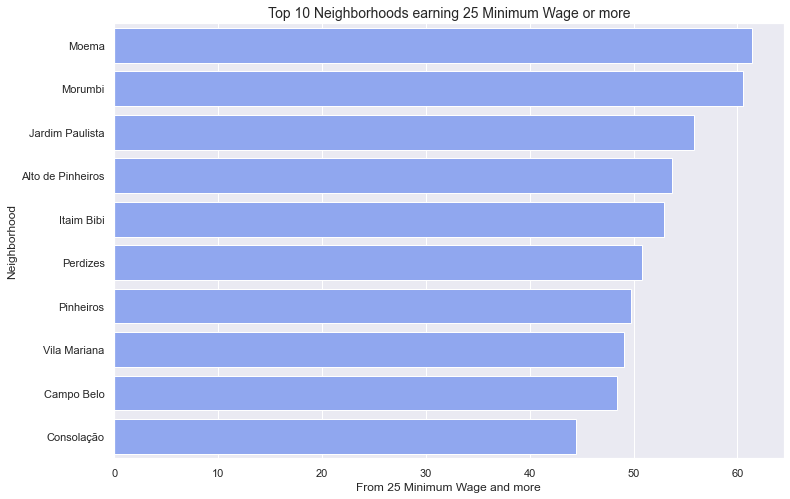

In [33]:
plt.figure(figsize=(12,8))
ax = sns.barplot(data=df_sp_geocoded_top_wage,
           y='Neighborhood',
           x='From 25 Minimum Wage and more', color='#809fff')
ax.set_title('Top 10 Neighborhoods earning 25 Minimum Wage or more', fontsize=14)

From the graph above, we can see that the top 10 neighborhoods with the majority of people earning 25 minimum wages or more are prevalent in two zones: South and West. The neighborhood with the highest percentage of people earning more than 25 minimum wages is "Moema", on the west side of the city

**Lets create a map of the neighborhoods of São Paulo that has the higher percentage of households who earn 25 or more minimum wage**

In [34]:
top_wage_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# adding GeoJson to the map
overlay = os.path.join('data', 'sp.json')
folium.GeoJson(overlay, name='sp',).add_to(top_wage_map)

# adding marks to the map
for lat, lng, neighborhood, subprefecture, zone in zip(df_sp_geocoded_top_wage['Latitude'],
                                                 df_sp_geocoded_top_wage['Longitude'],
                                                 df_sp_geocoded_top_wage['Neighborhood'],
                                                 df_sp_geocoded_top_wage['Subprefecture'],
                                                 df_sp_geocoded_top_wage['Zone']):
    label = '{}, {} - {}'.format(neighborhood, subprefecture, zone)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#70db70',
        fill_opacity=0.7).add_to(top_wage_map)

#display the map
top_wage_map

As we can see, there is not much dispersion between these neighborhoods, mainly occupying the South and West areas of the city of São Paulo.

**Now let's create a new data frame sorted by the households who earn less than 2 Minimum Wage**

In [35]:
df_sp_geocoded_less_wage = df_sp_geocoded[['Subprefecture', 'Neighborhood', 'Latitude',
                                           'Longitude', 'Less than 2 Minimum Wage', 'Zone']].sort_values(['Less than 2 Minimum Wage'], ascending=False).reset_index(drop=True)[:10]
df_sp_geocoded_less_wage

,Subprefecture,Neighborhood,Latitude,Longitude,Less than 2 Minimum Wage,Zone
0,Parelheiros,Marsilac,-23.937142,-46.710230,44.10,South
1,Parelheiros,Parelheiros,-23.824791,-46.733078,26.06,South
2,São Miguel,Jardim Helena,-23.482284,-46.423410,25.07,East
3,Guaianases,Lajeado,-23.536248,-46.410022,24.67,East
4,Itaim Paulista,Itaim Paulista,-23.501765,-46.399609,22.99,East
5,Capela do Socorro,Grajaú,-23.785907,-46.665197,22.92,South
6,São Mateus,Iguatemi,-23.618211,-46.418977,22.67,East
7,Itaim Paulista,Vila Curuçá,-23.510151,-46.417893,22.61,East
8,M'Boi Mirim,Jardim Ângela,-23.712528,-46.768720,22.18,South
9,São Mateus,São Rafael,-23.627159,-46.453241,21.34,East


**Let's visualize the neighborhoods where households earn less than 2 minimum wage**

Text(0.5, 1.0, 'Top 10 Neighborhoods earning less than 2 mininum wage')

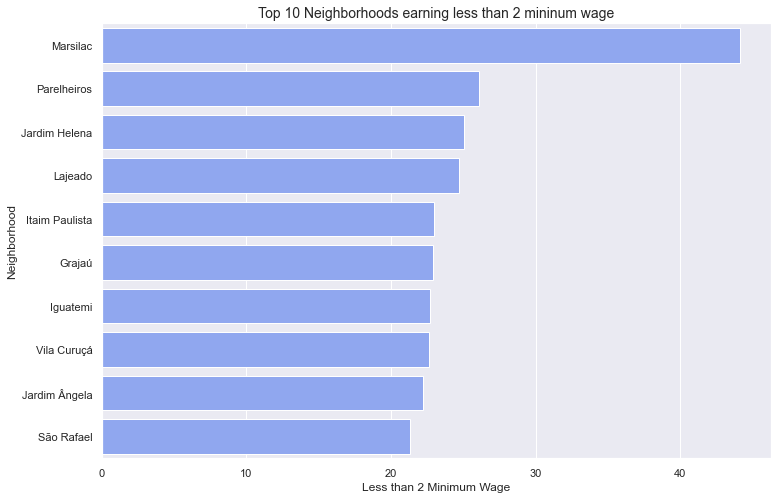

In [36]:
plt.figure(figsize=(12,8))
ax = sns.barplot(data=df_sp_geocoded_less_wage,
           y='Neighborhood',
           x='Less than 2 Minimum Wage', color='#809fff')
ax.set_title('Top 10 Neighborhoods earning less than 2 mininum wage', fontsize=14)

Now, we can see that the Neighborhoods wich most households earn less than 2 minimum wage are predominant in the South and East zones of the city. "Marsilac" is the neighborhood where almost 45% of the households earn less than 2 minimum wage.

**To compare, let's create a new map of São Paulo, with neighborhoods where families earn more than 25 minimum wages (green) and those that earn less than 2 minimum wages (red)**

In [37]:
comparative_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# adding GeoJson to the map
overlay = os.path.join('data', 'sp.json')
folium.GeoJson(overlay, name='sp',).add_to(comparative_map)

# adding marks from the less_wage data frame to the map
for lat, lng, neighborhood, subprefecture, zone in zip(df_sp_geocoded_less_wage['Latitude'],
                                                       df_sp_geocoded_less_wage['Longitude'],
                                                       df_sp_geocoded_less_wage['Neighborhood'],
                                                       df_sp_geocoded_less_wage['Subprefecture'],
                                                       df_sp_geocoded_less_wage['Zone']):
    label = '{}, {}'.format(neighborhood, subprefecture, zone)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#ff4d4d',
        fill_opacity=0.7).add_to(comparative_map)
    
# adding marks from the top_wage data frame to the map
for lat, lng, neighborhood, subprefecture, zone in zip(df_sp_geocoded_top_wage['Latitude'],
                                                       df_sp_geocoded_top_wage['Longitude'],
                                                       df_sp_geocoded_top_wage['Neighborhood'],
                                                       df_sp_geocoded_top_wage['Subprefecture'],
                                                       df_sp_geocoded_top_wage['Zone']):
    label = '{}, {}'.format(neighborhood, subprefecture, zone)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#70db70',
        fill_opacity=0.7).add_to(comparative_map)

#display the map
comparative_map

We can see by analyzing the above map, that the neighborhoods where people earn less than 2 minimum wages are more geographically dispersed, in the city, occupying mainly the East and South areas of São Paulo.

**Let's create a boxplot to visualize the distribution of the households who earn from 25 minimum wage and more**

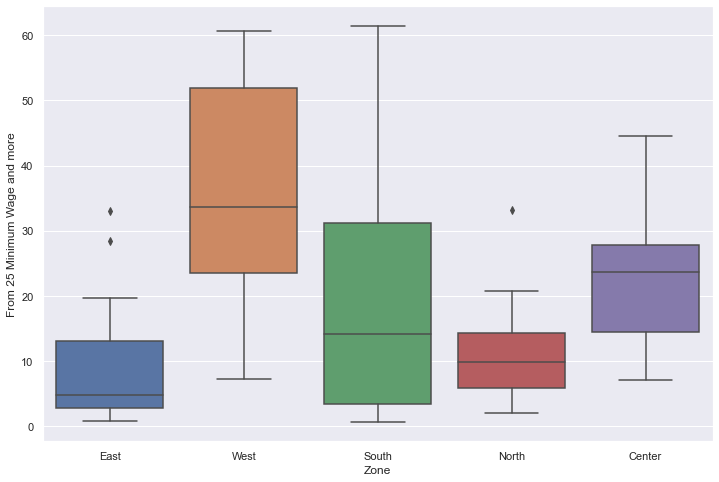

In [38]:
plt.figure(figsize=(12,8))
ax = sns.boxplot(x=df_sp_geocoded['Zone'], y=df_sp_geocoded['From 25 Minimum Wage and more'])
plt.show()

We can see that the West and South zones of the city have the highest distribution among households that earn at least 25 minimum wages. On the other hand, we see the East side of the city that has the lowest distriburion and also the one with the lowest percentage of households earning 25 minimum wages or more.

Now that we have a good understanding of the regions and neighborhoods in the city of São Paulo, we will use the Foursquare API and K-Means algorithm to get some information about the similarities between the neighborhoods

## Session 4 - Clustering

**In this session we are going to use Machine Learning algorithm _K-Means_ to cluster the neighborhoods of the city of São Paulo. With this approach we expect to get the similarities between the neighborhoods. This information will be usefull to recommend a better place to open a pet shop service in São Paulo.**

In [39]:
df_sp_geocoded.head()

,Subprefecture,Neighborhood,Latitude,Longitude,Less than 2 Minimum Wage,From 2 to Less than 5 Minimum Wage,From 5 to Less than 10 Minimum Wage,From 10 to Less than 15 Minimum Wage,From 15 to Less than 25 Minimum Wage,From 25 Minimum Wage and more,Zone
0,Aricanduva,Aricanduva,-23.578024,-46.511454,11.64,24.95,28.47,13.72,13.33,7.88,East
1,Aricanduva,Carrão,-23.551530,-46.537791,9.18,18.17,25.82,14.91,16.35,15.58,East
2,Aricanduva,Vila Formosa,-23.566876,-46.546323,8.10,20.08,28.69,13.91,13.08,16.14,East
3,Butantã,Butantã,-23.569056,-46.721883,4.93,10.60,16.23,12.10,18.25,37.88,West
4,Butantã,Morumbi,-23.596499,-46.717845,4.00,9.05,10.76,5.67,9.95,60.58,West


**Create a new data frame to use into k-means algorithm**

In [40]:
# drop non numeric columns
df_kmeans = df_sp_geocoded[['Less than 2 Minimum Wage',
                          'From 2 to Less than 5 Minimum Wage',
                          'From 5 to Less than 10 Minimum Wage',
                          'From 10 to Less than 15 Minimum Wage',
                          'From 15 to Less than 25 Minimum Wage',
                          'From 25 Minimum Wage and more']]
df_kmeans.head()

,Less than 2 Minimum Wage,From 2 to Less than 5 Minimum Wage,From 5 to Less than 10 Minimum Wage,From 10 to Less than 15 Minimum Wage,From 15 to Less than 25 Minimum Wage,From 25 Minimum Wage and more
0,11.64,24.95,28.47,13.72,13.33,7.88
1,9.18,18.17,25.82,14.91,16.35,15.58
2,8.10,20.08,28.69,13.91,13.08,16.14
3,4.93,10.60,16.23,12.10,18.25,37.88
4,4.00,9.05,10.76,5.67,9.95,60.58


In [41]:
# show the dimensions of the data frame
df_kmeans.shape

(96, 6)

In [42]:
# number of clusters
k_clusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=k_clusters, random_state=0).fit(df_kmeans)

# check cluster labels generated for each row in the data frame
kmeans.labels_

array([4, 2, 2, 1, 3, 4, 2, 1, 4, 0, 1, 4, 0, 1, 4, 2, 2, 4, 0, 0, 4, 4,
       0, 2, 0, 0, 2, 2, 2, 0, 0, 4, 4, 4, 4, 2, 4, 4, 1, 2, 2, 1, 3, 1,
       0, 4, 2, 2, 2, 1, 2, 1, 0, 0, 4, 4, 2, 2, 0, 0, 3, 3, 3, 3, 4, 2,
       2, 2, 1, 2, 3, 1, 3, 0, 0, 4, 4, 0, 0, 4, 1, 2, 2, 3, 1, 2, 1, 4,
       2, 4, 4, 3, 1, 3, 2, 2])

**Join the kmeans labels to the main data frame**

In [43]:
df_sp_geocoded['Cluster Labels'] = kmeans.labels_

In [44]:
# show the firsts rows of the data frame
df_sp_geocoded.head(20)

,Subprefecture,Neighborhood,Latitude,Longitude,Less than 2 Minimum Wage,From 2 to Less than 5 Minimum Wage,From 5 to Less than 10 Minimum Wage,From 10 to Less than 15 Minimum Wage,From 15 to Less than 25 Minimum Wage,From 25 Minimum Wage and more,Zone,Cluster Labels
0,Aricanduva,Aricanduva,-23.578024,-46.511454,11.64,24.95,28.47,13.72,13.33,7.88,East,4
1,Aricanduva,Carrão,-23.551530,-46.537791,9.18,18.17,25.82,14.91,16.35,15.58,East,2
2,Aricanduva,Vila Formosa,-23.566876,-46.546323,8.10,20.08,28.69,13.91,13.08,16.14,East,2
3,Butantã,Butantã,-23.569056,-46.721883,4.93,10.60,16.23,12.10,18.25,37.88,West,1
4,Butantã,Morumbi,-23.596499,-46.717845,4.00,9.05,10.76,5.67,9.95,60.58,West,3
5,Butantã,Raposo Tavares,-23.591610,-46.780359,12.73,27.95,29.05,12.50,10.54,7.24,West,4
6,Butantã,Rio Pequeno,-23.568505,-46.756857,11.80,22.00,22.77,12.38,13.08,17.96,West,2
7,Butantã,Vila Sônia,-23.599771,-46.739201,9.58,16.05,20.05,11.28,13.96,29.07,West,1
8,Campo Limpo,Campo Limpo,-23.632558,-46.759666,16.07,28.25,28.71,11.26,9.96,5.76,South,4
9,Campo Limpo,Capão Redondo,-23.671903,-46.779435,18.30,32.80,29.82,9.36,6.50,3.22,South,0


**Create a map to visualize the clusters**

In [45]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# adding GeoJson
overlay = os.path.join('data', 'sp.json')
folium.GeoJson(overlay, name='sp').add_to(map_clusters)

# setting the colors
x = np.arange(k_clusters)
ys = [i + x + (i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# adding markers
markers_colors = []
for lat, lng, poi, cluster in zip(df_sp_geocoded['Latitude'],
                                  df_sp_geocoded['Longitude'],
                                  df_sp_geocoded['Neighborhood'],
                                  df_sp_geocoded['Cluster Labels']):
    label_text = str(poi) + '/' + 'cluster: ' + str(cluster)
    label = folium.Popup(label_text, parse_html=True)
    folium.CircleMarker(
        location=[lat, lng],
        tooltip=label_text,
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_color_opacity=0.8).add_to(map_clusters)

map_clusters

As we can see from the above map of clusters, those neighborhoods wich is cluster 0, are on the periphery of the city of São Paulo, a place that has a little urban infrastructure, is more violent, and also poorer.

**Let's create a data frame for each cluster**

In [46]:
# cluster 0 data frame
df_cluster0 = df_sp_geocoded[df_sp_geocoded['Cluster Labels'] == 0]
df_cluster0.head()

,Subprefecture,Neighborhood,Latitude,Longitude,Less than 2 Minimum Wage,From 2 to Less than 5 Minimum Wage,From 5 to Less than 10 Minimum Wage,From 10 to Less than 15 Minimum Wage,From 15 to Less than 25 Minimum Wage,From 25 Minimum Wage and more,Zone,Cluster Labels
9,Campo Limpo,Capão Redondo,-23.671903,-46.779435,18.30,32.80,29.82,9.36,6.50,3.22,South,0
12,Capela do Socorro,Grajaú,-23.785907,-46.665197,22.92,35.87,28.21,7.55,4.08,1.38,South,0
18,Cidade Ademar,Pedreira,-23.696144,-46.637628,21.24,32.70,28.57,8.86,5.60,3.03,South,0
19,Cidade Tiradentes,Cidade Tiradentes,-23.582497,-46.409207,20.47,36.92,31.23,7.53,3.08,0.76,East,0
22,Freguesia do Ó,Brasilândia,-23.448272,-46.690269,19.87,34.23,28.27,9.15,5.99,2.49,North,0


In [47]:
print(f'We have {df_cluster0.shape[0]} neighborhoods in the cluster 0.')

We have 18 neighborhoods in the cluster 0.


**Let's check the distribution of the mean percentage of the neighborhoods into classes of wage**

In [48]:
numeric_columns = [col for col in df_cluster0.columns[4:-2] if df_cluster0[col].dtype == 'float']
for col in numeric_columns:
    print(f'{col}: {df_cluster0[col].mean():.2f}')

Less than 2 Minimum Wage: 22.77
From 2 to Less than 5 Minimum Wage: 35.54
From 5 to Less than 10 Minimum Wage: 27.81
From 10 to Less than 15 Minimum Wage: 7.83
From 15 to Less than 25 Minimum Wage: 4.26
From 25 Minimum Wage and more: 1.79


We can see that the neighborhoods in cluster 0 are those where families that earn a maximum of 10 minimum wages predominate, with the most representative group being those that earn between 2 and 5 minimum wages. They are located on the periphery of the city.

In [49]:
# cluster 1 data frame
df_cluster1 = df_sp_geocoded[df_sp_geocoded['Cluster Labels'] == 1]
df_cluster1.head()

,Subprefecture,Neighborhood,Latitude,Longitude,Less than 2 Minimum Wage,From 2 to Less than 5 Minimum Wage,From 5 to Less than 10 Minimum Wage,From 10 to Less than 15 Minimum Wage,From 15 to Less than 25 Minimum Wage,From 25 Minimum Wage and more,Zone,Cluster Labels
3,Butantã,Butantã,-23.569056,-46.721883,4.93,10.60,16.23,12.10,18.25,37.88,West,1
7,Butantã,Vila Sônia,-23.599771,-46.739201,9.58,16.05,20.05,11.28,13.96,29.07,West,1
10,Campo Limpo,Vila Andrade,-23.625687,-46.726989,14.15,25.13,17.41,5.50,6.37,31.44,South,1
13,Capela do Socorro,Socorro,-23.668885,-46.718615,8.65,13.72,24.01,12.82,17.58,23.22,South,1
38,Lapa,Barra Funda,-23.525462,-46.667513,6.66,11.23,23.98,12.87,14.22,31.04,West,1


In [50]:
print(f'We have {df_cluster1.shape[0]} neighborhoods in the cluster 1')

We have 15 neighborhoods in the cluster 1


In [51]:
numeric_columns = [col for col in df_cluster1.columns[4:-2] if df_cluster1[col].dtype == 'float']
for col in numeric_columns:
    print(f'{col}: {df_cluster1[col].mean():.2f}')

Less than 2 Minimum Wage: 6.55
From 2 to Less than 5 Minimum Wage: 13.57
From 5 to Less than 10 Minimum Wage: 20.22
From 10 to Less than 15 Minimum Wage: 11.95
From 15 to Less than 25 Minimum Wage: 16.53
From 25 Minimum Wage and more: 31.18


Cluster 1 neighborhoods are homogeneous among families earning 2 to 25 minimum wages, where the average does not vary as much, although we have the highest average for families earning more than 25 minimum wages.

In [52]:
# cluster 2 data frame
df_cluster2 = df_sp_geocoded[df_sp_geocoded['Cluster Labels'] == 2]
df_cluster2.head()

,Subprefecture,Neighborhood,Latitude,Longitude,Less than 2 Minimum Wage,From 2 to Less than 5 Minimum Wage,From 5 to Less than 10 Minimum Wage,From 10 to Less than 15 Minimum Wage,From 15 to Less than 25 Minimum Wage,From 25 Minimum Wage and more,Zone,Cluster Labels
1,Aricanduva,Carrão,-23.551530,-46.537791,9.18,18.17,25.82,14.91,16.35,15.58,East,2
2,Aricanduva,Vila Formosa,-23.566876,-46.546323,8.10,20.08,28.69,13.91,13.08,16.14,East,2
6,Butantã,Rio Pequeno,-23.568505,-46.756857,11.80,22.00,22.77,12.38,13.08,17.96,West,2
15,Casa Verde,Casa Verde,-23.505927,-46.656138,8.51,19.05,28.32,13.74,14.49,15.90,North,2
16,Casa Verde,Limão,-23.503315,-46.675272,11.30,24.80,25.49,14.25,13.54,10.62,North,2


In [53]:
print(f'We have {df_cluster2.shape[0]} neighborhoods in the cluster 2')

We have 28 neighborhoods in the cluster 2


In [54]:
numeric_columns = [col for col in df_cluster2.columns[4:-2] if df_cluster2[col].dtype == 'float']
for col in numeric_columns:
    print(f'{col}: {df_cluster2[col].mean():.2f}')

Less than 2 Minimum Wage: 9.77
From 2 to Less than 5 Minimum Wage: 20.03
From 5 to Less than 10 Minimum Wage: 26.52
From 10 to Less than 15 Minimum Wage: 14.07
From 15 to Less than 25 Minimum Wage: 14.62
From 25 Minimum Wage and more: 14.98


In cluster 2 we have the neighborhoods with the best income distribution, where it is not possible to verify a class much more representative than another, as the averages are very close.

In [55]:
# cluster 3 data frame
df_cluster3 = df_sp_geocoded[df_sp_geocoded['Cluster Labels'] == 3]
df_cluster3.head()

,Subprefecture,Neighborhood,Latitude,Longitude,Less than 2 Minimum Wage,From 2 to Less than 5 Minimum Wage,From 5 to Less than 10 Minimum Wage,From 10 to Less than 15 Minimum Wage,From 15 to Less than 25 Minimum Wage,From 25 Minimum Wage and more,Zone,Cluster Labels
4,Butantã,Morumbi,-23.596499,-46.717845,4.00,9.05,10.76,5.67,9.95,60.58,West,3
42,Lapa,Perdizes,-23.537930,-46.680671,2.70,5.45,12.84,10.72,17.47,50.83,West,3
60,Pinheiros,Alto de Pinheiros,-23.549461,-46.712293,3.47,5.44,12.22,9.30,15.85,53.72,West,3
61,Pinheiros,Itaim Bibi,-23.584381,-46.678444,3.87,6.61,12.98,8.83,14.78,52.92,West,3
62,Pinheiros,Jardim Paulista,-23.567436,-46.663692,2.43,4.04,11.97,9.17,16.61,55.78,West,3


In [56]:
print(f'We have {df_cluster3.shape[0]} neighborhoods in the cluster 3')

We have 11 neighborhoods in the cluster 3


In [57]:
numeric_columns = [col for col in df_cluster3.columns[4:-2] if df_cluster3[col].dtype == 'float']
for col in numeric_columns:
    print(f'{col}: {df_cluster3[col].mean():.2f}')

Less than 2 Minimum Wage: 3.53
From 2 to Less than 5 Minimum Wage: 6.52
From 5 to Less than 10 Minimum Wage: 13.33
From 10 to Less than 15 Minimum Wage: 9.32
From 15 to Less than 25 Minimum Wage: 15.47
From 25 Minimum Wage and more: 51.83


In cluster 3 we have the neighborhoods with the highest concentration of families earning over 25 minimum wages, and the lowest concentration for families earning up to 2 minimum wages.
The difference between the percentage of families earning more than 25 minimum wages in relation to the other classes is very large, which indicates that this is the cluster with the wealthiest neighborhoods in the city.

In [58]:
# cluster 4 data frame
df_cluster4 = df_sp_geocoded[df_sp_geocoded['Cluster Labels'] == 4]
df_cluster4.head()

,Subprefecture,Neighborhood,Latitude,Longitude,Less than 2 Minimum Wage,From 2 to Less than 5 Minimum Wage,From 5 to Less than 10 Minimum Wage,From 10 to Less than 15 Minimum Wage,From 15 to Less than 25 Minimum Wage,From 25 Minimum Wage and more,Zone,Cluster Labels
0,Aricanduva,Aricanduva,-23.578024,-46.511454,11.64,24.95,28.47,13.72,13.33,7.88,East,4
5,Butantã,Raposo Tavares,-23.591610,-46.780359,12.73,27.95,29.05,12.50,10.54,7.24,West,4
8,Campo Limpo,Campo Limpo,-23.632558,-46.759666,16.07,28.25,28.71,11.26,9.96,5.76,South,4
11,Capela do Socorro,Cidade Dutra,-23.713964,-46.699088,15.30,27.10,29.26,12.03,9.64,6.67,South,4
14,Casa Verde,Cachoeirinha,-23.449511,-46.663661,15.74,29.57,28.54,11.17,9.35,5.62,North,4


In [59]:
print(f'We have {df_cluster4.shape[0]} neighborhoods in the cluster 4')

We have 24 neighborhoods in the cluster 4


In [60]:
numeric_columns = [col for col in df_cluster4.columns[4:-2] if df_cluster4[col].dtype == 'float']
for col in numeric_columns:
    print(f'{col}: {df_cluster4[col].mean():.2f}')

Less than 2 Minimum Wage: 14.37
From 2 to Less than 5 Minimum Wage: 27.76
From 5 to Less than 10 Minimum Wage: 29.85
From 10 to Less than 15 Minimum Wage: 12.36
From 15 to Less than 25 Minimum Wage: 9.97
From 25 Minimum Wage and more: 5.69


In cluster 4 we have the neighborhoods with the highest concentration of families earning between 2 and 10 minimum wages. Also in this cluster, we can see the second highest concentration of families earning up to 2 minimum wages.

In [61]:
df_cluster3

,Subprefecture,Neighborhood,Latitude,Longitude,Less than 2 Minimum Wage,From 2 to Less than 5 Minimum Wage,From 5 to Less than 10 Minimum Wage,From 10 to Less than 15 Minimum Wage,From 15 to Less than 25 Minimum Wage,From 25 Minimum Wage and more,Zone,Cluster Labels
4,Butantã,Morumbi,-23.596499,-46.717845,4.00,9.05,10.76,5.67,9.95,60.58,West,3
42,Lapa,Perdizes,-23.537930,-46.680671,2.70,5.45,12.84,10.72,17.47,50.83,West,3
60,Pinheiros,Alto de Pinheiros,-23.549461,-46.712293,3.47,5.44,12.22,9.30,15.85,53.72,West,3
61,Pinheiros,Itaim Bibi,-23.584381,-46.678444,3.87,6.61,12.98,8.83,14.78,52.92,West,3
62,Pinheiros,Jardim Paulista,-23.567436,-46.663692,2.43,4.04,11.97,9.17,16.61,55.78,West,3
63,Pinheiros,Pinheiros,-23.566426,-46.703055,3.77,5.98,14.34,9.60,16.53,49.79,West,3
70,Santo Amaro,Campo Belo,-23.626731,-46.669429,4.92,9.48,13.81,9.90,13.45,48.44,South,3
72,Santo Amaro,Santo Amaro,-23.656230,-46.719116,4.17,6.84,16.87,10.41,18.59,43.13,South,3
83,Sé,Consolação,-23.557818,-46.660537,3.77,8.33,17.19,10.49,15.74,44.47,Center,3
91,Vila Mariana,Moema,-23.597085,-46.662888,2.91,3.43,9.95,8.55,13.78,61.38,South,3


**Discussion:** After analyzing the clusters, we can consider cluster 3 as the installation of the pet service, as it concentrates the wealthiest neighborhoods in the city (highest percentage of families earning above 25 minimum wages). In this cluster we have neighborhoods like _Morumbi_, _Perdizes_ and _Alto de Pinheiros_, which are known to be great neighborhoods to live in, with excellent infrastructure, and low violence.

**Save the clusters data frames**

In [62]:
df_cluster0.to_csv('data/cluster0.csv', index=False)
df_cluster1.to_csv('data/cluster1.csv', index=False)
df_cluster2.to_csv('data/cluster2.csv', index=False)
df_cluster3.to_csv('data/cluster3.csv', index=False)
df_cluster4.to_csv('data/cluster4.csv', index=False)

## Session 5 - Exploring the Neighborhoods of São Paulo

In this session, we will use the Foursquare API to further explore the neighborhoods in cluster 3 and analyze which types of venues predominate in these neighborhoods.

In [63]:
df_cluster3 = pd.read_csv('data/cluster3.csv')
df_cluster3.head()

,Subprefecture,Neighborhood,Latitude,Longitude,Less than 2 Minimum Wage,From 2 to Less than 5 Minimum Wage,From 5 to Less than 10 Minimum Wage,From 10 to Less than 15 Minimum Wage,From 15 to Less than 25 Minimum Wage,From 25 Minimum Wage and more,Zone,Cluster Labels
0,Butantã,Morumbi,-23.596499,-46.717845,4.00,9.05,10.76,5.67,9.95,60.58,West,3
1,Lapa,Perdizes,-23.537930,-46.680671,2.70,5.45,12.84,10.72,17.47,50.83,West,3
2,Pinheiros,Alto de Pinheiros,-23.549461,-46.712293,3.47,5.44,12.22,9.30,15.85,53.72,West,3
3,Pinheiros,Itaim Bibi,-23.584381,-46.678444,3.87,6.61,12.98,8.83,14.78,52.92,West,3
4,Pinheiros,Jardim Paulista,-23.567435,-46.663692,2.43,4.04,11.97,9.17,16.61,55.78,West,3


**Defining Foursquare Credentials and Version**

In [64]:
CLIENT_ID = 'XXX' # your Foursquare ID
CLIENT_SECRET = 'XXX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

**Let's explore the neighborhoods in the cluster 3**

In [65]:
def get_nearby_venues(names, latitudes, longitudes, radius=5000):
    venues_list = []
    
    for name, lat, lng, in zip(names, latitudes, longitudes):
        print(name)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
        name,
        lat,
        lng,
        v['venue']['name'],
        v['venue']['location']['lat'],
        v['venue']['location']['lng'],
        v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                            'Neighborhood Latitude',
                            'Neighborhood Longitude',
                            'Venue',
                            'Venue Latitude',
                            'Venue Longitude',
                            'Venue Category']
    return(nearby_venues)

In [66]:
sp_venues = get_nearby_venues(names=df_cluster3['Neighborhood'],
                             latitudes=df_cluster3['Latitude'],
                             longitudes=df_cluster3['Longitude'])

Morumbi
Perdizes
Alto de Pinheiros
Itaim Bibi
Jardim Paulista
Pinheiros
Campo Belo
Santo Amaro
Consolação
Moema
Vila Mariana


**Let's check the size of the new data frame**

In [67]:
sp_venues.shape

(1100, 7)

In [68]:
sp_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Morumbi,-23.596499,-46.717845,Colégio Miguel de Cervantes,-23.593842,-46.719378,High School
1,Morumbi,-23.596499,-46.717845,Kopenhagen,-23.599882,-46.714562,Chocolate Shop
2,Morumbi,-23.596499,-46.717845,Praça Vinícius de Moraes,-23.597438,-46.711746,Plaza
3,Morumbi,-23.596499,-46.717845,Santa Bárbara Central de Carnes,-23.589059,-46.716031,BBQ Joint
4,Morumbi,-23.596499,-46.717845,São Paulo Futebol Clube (SPFC),-23.602260,-46.720317,Social Club


**Now let's check how many venues were returned for each neighborhood**

In [69]:
sp_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Alto de Pinheiros,100,100,100,100,100,100
Campo Belo,100,100,100,100,100,100
Consolação,100,100,100,100,100,100
Itaim Bibi,100,100,100,100,100,100
Jardim Paulista,100,100,100,100,100,100
Moema,100,100,100,100,100,100
Morumbi,100,100,100,100,100,100
Perdizes,100,100,100,100,100,100
Pinheiros,100,100,100,100,100,100


**Let's check how many unique categories can be curated from all returned venues**

In [70]:
print(f"There are {len(sp_venues['Venue Category'].unique())} uniques categories")

There are 156 uniques categories


### Analizing each neighborhood

In [71]:
# one hot encoding
sp_onehot = pd.get_dummies(sp_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to data frame
sp_onehot['Neighborhood'] = sp_venues['Neighborhood']

# move neighborhood column to the first column
fixed_columns = [sp_onehot.columns[-1]] + list(sp_onehot.columns[:-1])
sp_onehot = sp_onehot[fixed_columns]

sp_onehot.head()

,Neighborhood,Accessories Store,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,...,Tea Room,Tennis Court,Theater,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Morumbi,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Morumbi,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Morumbi,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Morumbi,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Morumbi,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Let's examine the new data frame size**

In [72]:
sp_onehot.shape

(1100, 157)

**Now, let's group rows by neighborhood and by taking the mean of the frequency of occurence of each category**

In [73]:
sp_grouped = sp_onehot.groupby('Neighborhood').mean().reset_index()
sp_grouped

,Neighborhood,Accessories Store,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,...,Tea Room,Tennis Court,Theater,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Alto de Pinheiros,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.03,...,0.01,0.00,0.02,0.01,0.00,0.01,0.01,0.00,0.00,0.01
1,Campo Belo,0.01,0.00,0.00,0.01,0.00,0.00,0.00,0.02,0.05,...,0.01,0.00,0.00,0.00,0.00,0.02,0.00,0.01,0.00,0.00
2,Consolação,0.00,0.01,0.03,0.00,0.00,0.01,0.00,0.01,0.00,...,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.01
3,Itaim Bibi,0.00,0.01,0.02,0.00,0.00,0.02,0.00,0.01,0.00,...,0.00,0.00,0.02,0.00,0.00,0.01,0.01,0.00,0.00,0.01
4,Jardim Paulista,0.00,0.01,0.03,0.00,0.00,0.01,0.00,0.02,0.00,...,0.00,0.00,0.01,0.00,0.00,0.01,0.01,0.00,0.00,0.02
5,Moema,0.01,0.00,0.03,0.00,0.00,0.02,0.00,0.01,0.05,...,0.00,0.00,0.01,0.00,0.00,0.02,0.00,0.00,0.00,0.01
6,Morumbi,0.00,0.00,0.00,0.00,0.01,0.02,0.02,0.00,0.02,...,0.00,0.00,0.02,0.00,0.00,0.01,0.00,0.00,0.00,0.00
7,Perdizes,0.00,0.02,0.00,0.00,0.00,0.01,0.00,0.00,0.01,...,0.01,0.00,0.01,0.00,0.00,0.01,0.00,0.00,0.01,0.00
8,Pinheiros,0.00,0.01,0.02,0.00,0.00,0.03,0.02,0.01,0.01,...,0.00,0.00,0.01,0.01,0.00,0.01,0.01,0.00,0.00,0.00
9,Santo Amaro,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.03,0.03,...,0.01,0.02,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00


**Let's confirm the new size**

In [74]:
sp_grouped.shape

(11, 157)

**Let's print each neighborhood along with the top 10 most common venues**

In [75]:
num_top_venues = 10

for hood in sp_grouped['Neighborhood']:
    print("-----"+hood+"-----")
    temp = sp_grouped[sp_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

-----Alto de Pinheiros-----
                  venue  freq
0        Ice Cream Shop  0.05
1  Brazilian Restaurant  0.04
2             Pet Store  0.04
3                 Plaza  0.04
4           Flower Shop  0.04
5           Pizza Place  0.03
6                   Bar  0.03
7          Dessert Shop  0.03
8                Hostel  0.03
9    Italian Restaurant  0.03


-----Campo Belo-----
                  venue  freq
0        Ice Cream Shop  0.07
1                   Bar  0.05
2  Brazilian Restaurant  0.05
3             Pet Store  0.04
4           Pizza Place  0.04
5          Burger Joint  0.04
6           Coffee Shop  0.04
7                   Gym  0.03
8          Dessert Shop  0.03
9    Italian Restaurant  0.03


-----Consolação-----
                  venue  freq
0        Ice Cream Shop  0.10
1  Brazilian Restaurant  0.06
2                  Café  0.05
3                 Hotel  0.04
4           Pizza Place  0.04
5               Theater  0.03
6                   Gym  0.03
7            Restaurant  0

**Let's put that into a data frame. First, let's write a function to sort the venues in descending order**

In [76]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

**Now, let's create a new data frame and display the top 10 venues for each neighborhood**

In [77]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a data frame
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = sp_grouped['Neighborhood']

for ind in np.arange(sp_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sp_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alto de Pinheiros,Ice Cream Shop,Pet Store,Brazilian Restaurant,Flower Shop,Plaza,Pizza Place,Dessert Shop,Coffee Shop,Hostel,Bar
1,Campo Belo,Ice Cream Shop,Brazilian Restaurant,Bar,Pizza Place,Coffee Shop,Burger Joint,Pet Store,Mineiro Restaurant,Gym,Dessert Shop
2,Consolação,Ice Cream Shop,Brazilian Restaurant,Café,Pizza Place,Hotel,Art Museum,Gym,Restaurant,Theater,Bookstore
3,Itaim Bibi,Ice Cream Shop,Restaurant,Italian Restaurant,Gym / Fitness Center,Cycle Studio,Pet Store,Brazilian Restaurant,French Restaurant,Cosmetics Shop,Hotel
4,Jardim Paulista,Ice Cream Shop,Bookstore,Brazilian Restaurant,Pet Store,Hotel,Pizza Place,Art Museum,Gym,Italian Restaurant,Café
5,Moema,Ice Cream Shop,Bar,Restaurant,Italian Restaurant,Art Museum,Gym,Cycle Studio,Park,Chocolate Shop,Salad Place
6,Morumbi,Gym / Fitness Center,Gym,Shopping Mall,Coffee Shop,Ice Cream Shop,Hotel,Pharmacy,Cosmetics Shop,Park,Butcher
7,Perdizes,Ice Cream Shop,Pizza Place,Pet Store,Plaza,Brazilian Restaurant,Park,Italian Restaurant,Hostel,Café,Bookstore
8,Pinheiros,Italian Restaurant,Plaza,Ice Cream Shop,Brazilian Restaurant,French Restaurant,Athletics & Sports,Fruit & Vegetable Store,Hostel,Coffee Shop,Restaurant
9,Santo Amaro,Gym / Fitness Center,Pet Store,Supermarket,Hotel,Italian Restaurant,Bar,Bakery,Steakhouse,Gym,Coffee Shop


**Considerations:** When analyzing the data frame above, we can see that **_Pet Store_** is a very common category in the neighborhoods of **cluster 3**. This category is **_one of the 10 most common in 6 of the 11 neighborhoods analyzed_**, being the most common in _Santo Amaro_ and the second most common in _Perdizes_.

In this first moment, we can consider the neighborhoods _Consolação_, _Moema_, _Morumbi_, _Pinheiros_ and _Vila Mariana_ as potential neighborhoods for the installation of the pet shop service.

**Let's create a data frame with only these potential neighborhoods**

In [78]:
df_cluster3_filtered = df_cluster3[(df_cluster3['Neighborhood'] == 'Consolação') |
                                   (df_cluster3['Neighborhood'] == 'Moema') |
                                   (df_cluster3['Neighborhood'] == 'Morumbi') |
                                   (df_cluster3['Neighborhood'] == 'Pinheiros') |
                                   (df_cluster3['Neighborhood'] == 'Vila Mariana')]
df_cluster3_filtered.reset_index(drop=True)

,Subprefecture,Neighborhood,Latitude,Longitude,Less than 2 Minimum Wage,From 2 to Less than 5 Minimum Wage,From 5 to Less than 10 Minimum Wage,From 10 to Less than 15 Minimum Wage,From 15 to Less than 25 Minimum Wage,From 25 Minimum Wage and more,Zone,Cluster Labels
0,Butantã,Morumbi,-23.596499,-46.717845,4.00,9.05,10.76,5.67,9.95,60.58,West,3
1,Pinheiros,Pinheiros,-23.566426,-46.703055,3.77,5.98,14.34,9.60,16.53,49.79,West,3
2,Sé,Consolação,-23.557818,-46.660537,3.77,8.33,17.19,10.49,15.74,44.47,Center,3
3,Vila Mariana,Moema,-23.597085,-46.662888,2.91,3.43,9.95,8.55,13.78,61.38,South,3
4,Vila Mariana,Vila Mariana,-23.583700,-46.632741,2.87,7.03,13.69,9.90,17.47,49.05,South,3


**Now we create a function to list the pet store venues in each potencial neighborhood**

In [79]:
def get_pet_venues(names, latitudes, longitudes):
    pet_venues_list = []
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)

        # create API request URL
        url = 'https://api.foursquare.com/v2/venues/explore'

        params = dict(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET,
        v='20180605',
        ll=f'{lat},{lng}',
        query='Pet Store',
        radius=1000,
        limit=100
        )
        resp = requests.get(url=url, params=params)
        data = json.loads(resp.text)

        results = data['response']['groups'][0]['items']

        # return only relevant information
        pet_venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['id'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])
  
    pet_venues = pd.DataFrame([item for venue_list in pet_venues_list for item in venue_list])
    pet_venues.columns = ['Neighborhood',
                               'Neighborhood Latitude',
                               'Neighborhood Longitude',
                               'Venue',
                               'ID',
                               'Venue Latitude',
                               'Venue Longitude',
                               'Venue Category']
    return (pet_venues)

**Create a data frame for the pet shop venues**

In [80]:
pet_venues = get_pet_venues(names=df_cluster3_filtered['Neighborhood'],
                             latitudes=df_cluster3_filtered['Latitude'],
                             longitudes=df_cluster3_filtered['Longitude'])

Morumbi
Pinheiros
Consolação
Moema
Vila Mariana


In [81]:
pet_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,ID,Venue Latitude,Venue Longitude,Venue Category
0,Morumbi,-23.596499,-46.717845,BB Dogs & Cats,4d0f581bd467236a9d93bd4a,-23.591229,-46.720096,Pet Store
1,Morumbi,-23.596499,-46.717845,Mundo Zoo,4bb78f58cf2fc9b6b1669e02,-23.590506,-46.716664,Pet Store
2,Morumbi,-23.596499,-46.717845,Eco Pet Store do Brasil,4f92dcc7e4b0c98ce0335efa,-23.590095,-46.717255,Pet Store
3,Morumbi,-23.596499,-46.717845,Metazooa Pet Store,4e5bf9d2d4c0c4d56970643b,-23.591000,-46.719302,Pet Store
4,Morumbi,-23.596499,-46.717845,Club Pet Shop,578ccc69498e2228cf4fe9e0,-23.590047,-46.717298,Pet Store
5,Morumbi,-23.596499,-46.717845,Mimos,4c001fc737850f4742c6973f,-23.589087,-46.719921,Pet Store
6,Pinheiros,-23.566426,-46.703055,Vida Animal,56c5a366cd101c2cce4989c8,-23.561675,-46.700191,Pet Store
7,Pinheiros,-23.566426,-46.703055,Mundo Animal,4da9a5374b22f071eaa3935b,-23.573143,-46.703809,Pet Store
8,Pinheiros,-23.566426,-46.703055,Pet home Grupo Filhotes Net,4fc7bcdbe4b0b85ee23d076a,-23.571783,-46.710041,Pet Store
9,Pinheiros,-23.566426,-46.703055,meuamigopet,51325ee0e4b090129808129e,-23.572834,-46.696793,Pet Store


**Let's look for the neighborhoods that presents the minimum competition for a new pet shop service.**

In [82]:
pet_venues['Neighborhood'].value_counts(ascending=True)

Pinheiros        4
Morumbi          6
Moema           15
Vila Mariana    18
Consolação      21
Name: Neighborhood, dtype: int64

## Conclusion

After analyzing the neighborhoods in the city of São Paulo, it can be concluded that there are 3 potential neighborhoods to start a pet shop service, they are: _Pinheiros_, _Morumbi_, and _Moema_.

- **1st: Pinheiros**: is known as a neighborhood that receives people from the most diverse backgrounds: students, businessmen, musicians and artists. Likewise, commerce is wide and varied: trendy restaurants, bars, offices of large companies, luxury shopping malls and popular stores. Parks, renowned hospitals, schools and universities of excellence are also nearby. It is a mix of residential and commercial spaces. We can expect low competitiveness for the new pet shop service, since we found only 4 registered pet shops in the neighborhood.


- **2nd: Morumbi**: Neighborhood located in the West Zone of the city of Sâo Paulo, has excellent infrastructure and has hotels, shopping malls, hospitals, restaurants and commercial buildings. Morumbi also has the second highest percentage of residents earning 25 minimum wages or more, and among the neighborhoods above it is the one with the second lowest number of pet shops, only 6. Low competitiveness and high income residents are good factors to start a pet shop service in the neighborhood.


- **3rd: Moema**:  Neighborhood located in the South Zone of São Paulo. Like the other neighborhoods already mentioned, it has excellent infrastructure and services. Among the neighborhoods where residents earn 25 minimum wages or more, it occupies the eighth position. Potential competitiveness is expected for a pet shop service, since 18 services of this category were registered in the neighborhood.